<a href="https://colab.research.google.com/github/jojoclt/C/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Loading Data and importing Library

Please add the [FOLDER](https://drive.google.com/drive/folders/1nrhaTZC-0wGPOKA1ZwVdmmB2U1NqrMsJ?usp=sharing) to your root directory of Google Drive.
[paper link](https://www.researchgate.net/publication/330154837_Ripeness_Classification_of_Bananas_Using_an_Artificial_Neural_Network
)

also please join [trello](https://trello.com/b/uPv9MgUv/ml-proj-banana)

Data arr; dataset, dataset_label

data_processed

data_segmented

In [20]:
#TO RUN
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#TO RUN
import sys
import os
# sys.path.append('/content/drive/MyDrive/Project/')
if (os.getcwd() == '/content'): 
    os.chdir('./drive/MyDrive/Project')

In [22]:
#TO RUN
import os
import math
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#image filter
import skimage
import gf
from skimage.color import hsv2rgb
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2

from itertools import repeat
from collections import Counter

# 1. Inputting Data

In [23]:
#TO RUN: load dataset
PATH='Fayoum_University_Banana _Classes'
folder_name = os.listdir(PATH)
dataset = []

# Green 104 Midripen 88 Overripen 33 Yellowish_green 48
data_keys = ('g','m','v','y')
dataset_label = []

for name in sorted(folder_name):
    subfolder = os.path.join(PATH, name)
    for fh in sorted(os.listdir(subfolder)):
        file_name = os.path.join(subfolder,fh)
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        dataset.append(img)
        dataset_label.append(data_keys.index(fh[0]))

# 2. Image Preprocessing

Gonna Find the highest occurences of shapes, then reshape to the most occuring shape.

In [24]:
c = Counter([ele.shape for ele in dataset])
c

Counter({(540, 960, 3): 118,
         (1072, 1920, 3): 1,
         (536, 960, 3): 153,
         (636, 960, 3): 1})

In [25]:
#TO RUN: def function for preprocessing image
data_processed = []
ker = 5
iter = 1
r = 5
eps = 0.05

# cv2 width height reversed https://stackoverflow.com/a/22094421
IMG_SIZE = (960,536)

def process_image(img, ker = 5, iter = (2,2,5), r = 5, eps = 0.05):
    # Step 0: Resize Image
    img_resize = cv2.resize(img.astype(np.uint8), IMG_SIZE)

    # Step 1: Applying Guided Filter to preserve edges and smoothing on img
    # https://blog.csdn.net/youcans/article/details/122008763
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgproc_bgr = cv2.ximgproc.guidedFilter(img_resize, img_resize, r, eps)
    # return imgproc_bgr
    # Step 2: convert RGB to HSV
    # hsv_img = cv2.cvtColor(imgproc_bgr, cv2.COLOR_BGR2HSV)

    # Step 3: Morphological Filtering 
    # https://towardsdatascience.com/image-processing-class-egbe443-6-morphological-filter-e952c1ec886e
    kernel = np.ones((10, 10), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_otsu_clean = cv2.morphologyEx(imgproc_bgr, cv2.MORPH_OPEN, kernel, iterations=5)
    mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=5)
    mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=2)
    # mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=4)
    # mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=3)
    return mask_otsu_clean
# show_mask(mask_otsu_clean, c, title='Otsu grayscale thresholding with morphological cleanup')
    # kernel = np.ones((ker,ker),np.uint8)
    # # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ker,ker))
    # cleaned = cv2.morphologyEx(hsv_img)
    # # morph = cv2.morphologyEx(hsv_img, cv2.MORPH_CLOSE, kernel, iterations = iter)
    
    # return morph

In [ ]:
# in HSV
data_processed = np.array(list(map(process_image, dataset, repeat(ker), repeat(iter), repeat(r), repeat(eps))))

In [ ]:
c = Counter([ele.shape for ele in data_processed])
c

#3. Fruit Segmentation


Segment Image using Otsu's method (cv2 results not promising, using skimage)

Helper

In [ ]:
def hsv2gray(img):
    return rgb2gray(hsv2rgb(img))
def gray2hsv(img):
    return rgb2hsv(gray2rgb(img))
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
def HSV_to_cv(h,s,v):
    return (h/2, s/100 * 255, v/100 * 255)

In [ ]:
def show_intensity_histogram(image):
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.hist(image_grayscale.ravel(), 256)
    plt.title('Intensity histogram')
    plt.ylabel('Number of pixels')
    plt.xlabel('Light intensity')
    plt.show()

In [ ]:
pic = process_image(dataset[270],r=10,eps=0.06)
plt.figure(figsize=(20,20))
plt.subplot(121),plt.axis('off'),plt.title('Original')
plt.imshow(cv2.cvtColor(dataset[270],cv2.COLOR_BGR2RGB))
plt.subplot(122),plt.axis('off'),plt.title('Proc')
plt.imshow(cv2.cvtColor(pic,cv2.COLOR_BGR2RGB))

In [ ]:
show_intensity_histogram(dataset[0])
show_intensity_histogram(data_processed[0])

In [ ]:
clahe = cv2.createCLAHE(clipLimit = 7)
pic = cv2.cvtColor(dataset[200],cv2.COLOR_BGR2GRAY)
final_img = clahe.apply(pic) + 50
_, ordinary_img = cv2.threshold(pic, 155, 255, cv2.THRESH_BINARY)
 
# Showing all the three images
# plt.imshow(ordinary_img)
plt.imshow(final_img)
# plt.imshow(dataset[200])

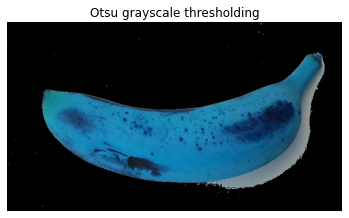

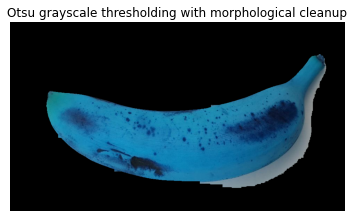

In [19]:
# https://stackoverflow.com/questions/59235904/how-to-remove-shadows-from-foreground-after-segmentation
def show_mask(mask, image, title='', mask_color=(0, 0, 0)):
    display_image = image.copy()
    display_image[mask != 0] = mask_color
    plt.imshow(display_image)
    plt.title(title)
    plt.axis('off')
    plt.show()
def compute_otsu_mask(image):
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# plt.imshow(bgr2rgb(dataset[240]))
# c = cv2.cvtColor(final_img,cv2.COLOR_GRAY2BGR)
l = np.random.randint(0,272)
c = dataset[l]
mask_otsu = compute_otsu_mask(c)
show_mask(mask_otsu, c, title='Otsu grayscale thresholding')
def lol(mask_otsu):
    kernel = np.ones((5, 5), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_otsu_clean = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel, iterations=5)
    mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=2)
    mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=5)
    mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=4)
    mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=3)
    return mask_otsu_clean
show_mask(lol(mask_otsu), c, title='Otsu grayscale thresholding with morphological cleanup')

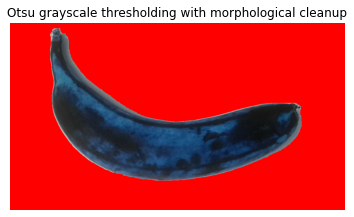

In [144]:
def lol(mask_otsu):
    kernel = np.ones((5, 5), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_otsu_clean = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel, iterations=5)
    mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=2)
    mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel2, iterations=5)
    mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=4)
    mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=3)
    return mask_otsu_clean
show_mask(lol(mask_otsu), c, title='Otsu grayscale thresholding with morphological cleanup')

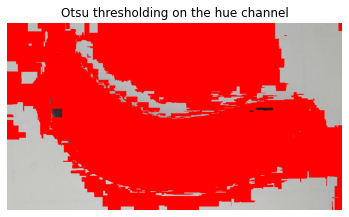

In [143]:
def compute_otsu_mask_hue(image):
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    hue, lightness, saturation = np.split(image_hls, 3, axis=2)

    hue = hue.reshape((hue.shape[0], hue.shape[1]))

    otsu = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    otsu_mask = otsu != 255

    return otsu_mask
l = np.random.randint(0,270)
c = dataset[210]
mask_otsu_hue = compute_otsu_mask_hue(process_image(c))
show_mask(mask_otsu_hue, c, title='Otsu thresholding on the hue channel')

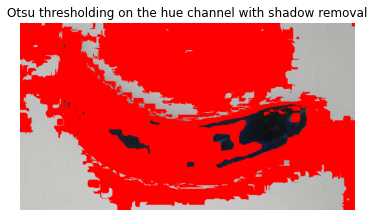

In [133]:
def compute_otsu_mask_shadows(image, shadow_percentile=5):
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    hue, lightness, saturation = np.split(image_hls, 3, axis=2)
    hue = hue.reshape((hue.shape[0], hue.shape[1]))

    otsu = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    otsu_mask = otsu != 255

    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = np.split(image_lab, 3, axis=2)
    l = l.reshape((l.shape[0], l.shape[1]))

    shadow_threshold = np.percentile(l.ravel(), q=shadow_percentile)
    shadows_mask = l < shadow_threshold

    mask = otsu_mask ^ shadows_mask

    return mask

mask_otsu_shadows = compute_otsu_mask_shadows(lol(c))
show_mask(mask_otsu_shadows, c, title='Otsu thresholding on the hue channel with shadow removal')

In [52]:
kernel = np.ones((5, 5), np.uint8)
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
mask_otsu_clean = cv2.morphologyEx(mask_otsu_shadows, cv2.MORPH_OPEN, kernel, iterations=5)
mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=2)
mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel2, iterations=5)
mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=4)
mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=3)
show_mask(mask_otsu_clean, c, title='Otsu grayscale thresholding with morphological cleanup')

error: ignored

---


In [ ]:
# Must use data_processed as input
def segmentation_mask(img, enabled = False):
    image = hsv2gray(img)
    thresh = threshold_otsu(image)
    mask = (image <= thresh).astype(int)
    if (enabled): plt.imshow(mask, cmap='gray')
    return mask

In [ ]:
def segment_image(img):
    mask = segmentation_mask(img)
    masked = np.zeros_like(img)
    for i in range(3): 
        masked[:,:,i] = np.where(mask, img[:,:,i], 0)
    return masked

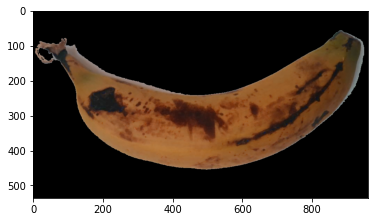

In [ ]:
img = data_processed[110]
v = segment_image(img)
plt.imshow(hsv2rgb(v))

In [ ]:
def guided_filter_color(img, r=4, eps=0.05, s=4):
    smoothed = np.zeros_like(img)
    for i in range(3):
        smoothed[:,:,i] = gf.guided_filter(img,img[:,:,i],r,eps,s)
    return smoothed

In [ ]:
a=guided_filter_color(dataset[110])

In [ ]:
b = segment_image(rgb2hsv(a))
plt.imshow(b)

NameError: ignored

In [ ]:
def segment_spots(img):
    # https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
    # HSV Inconsistencies

    # Normal H = 0-360, S = 0-100 and V = 0-100. 
    # But OpenCV uses H: 0-179, S: 0-255, V: 0-255.
    # (H/2, (S/100) * 255, (V/100) * 255) 
    lower_bound = HSV_to_cv(30, 66, 4.7)
    upper_bound = HSV_to_cv(30, 67.6, 60)

    # Create the mask using cv2.inRange()
    mask = cv2.inRange(img, lower_bound, upper_bound)

    # # Apply the mask to the original image using cv2.bitwise_and()
    # result = cv2.bitwise_and(hsv2rgb(img), hsv2rgb(img), mask=mask)
    return mask

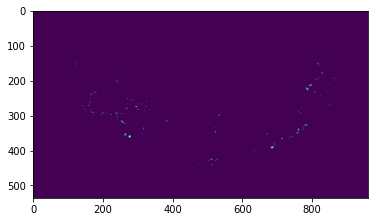

In [ ]:
a = segment_spots(v)
plt.imshow(a)

#Hidden


In [ ]:
#try
# image = data_resize[51]
# image = process_image(cv2.imread('/content/179394.jpg'))
# rand = np.random.randint(len(dataset))
rand = np.random.randint(low=104+88, high=104+88+33)
# try 270 and 205, if works then ok
image = process_image(dataset[193],0,8,0,6,r=5,eps=0.02)
# image = data_processed[50]
gray = cv2.cvtColor((image), cv2.COLOR_BGR2GRAY)

# # Apply Otsu's method
threshold, thresholded_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # The foreground pixels will be white and the background pixels will be black
# # in the thresholded image
foreground = cv2.bitwise_and(image, image, mask=thresholded_image)
background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(thresholded_image))
plt.figure(figsize=(20,20))
plt.subplot(131)
# plt.imshow(foreground)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_HSV2RGB))
plt.subplot(132)
# plt.imshow(cv2.cvtColor(foreground,cv2.COLOR_HSV2RGB))
plt.imshow(thresholded_image) #bg = 0, bnn = 255
z = np.zeros((image.shape)).astype(np.uint8)
bnn = np.where(thresholded_image>0)
for i in range(len(bnn[0])):
  z[bnn[0][i]][bnn[1][i]] = image[bnn[0][i]][bnn[1][i]]
#it work but i can't plt it
plt.subplot(133)
plt.imshow(cv2.cvtColor(z,cv2.COLOR_HSV2RGB))

In [ ]:
segment_image(data_processed[270], True)

In [ ]:
#TO RUN: def function to seperate image from background
#TO IMPROVE: it still cut off some part of banana + not sure the threshold is global enough
def image_segment(img):
  filtered_image = process_image(img,ker=25,r=10,eps=0.05)
  grayed_filtered_img = cv2.cvtColor((filtered_image), cv2.COLOR_BGR2GRAY)

  # # Apply Otsu's method
  threshold, thresholded_image = cv2.threshold(grayed_filtered_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # segmented thresholded_img
  segmented_img = np.zeros((img.shape))
  segment_area = np.where(thresholded_image>0)
  for i in range(len(segment_area[0])):
    segmented_img[segment_area[0][i]][segment_area[1][i]] = img[segment_area[0][i]][segment_area[1][i]]

  return segmented_img



##testing segmentation

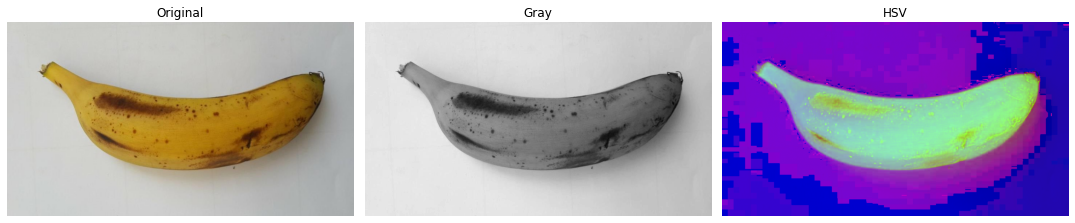

In [ ]:
#test if we should use hsv or grayscale
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))
gray_bnn = rgb2gray(bnn_samp)
hsv_bnn = rgb2hsv(bnn_samp)
#try re-color
#re_bnn = gray2rgb(gray_bnn)
plt.figure(figsize=(20,20))
plt.subplot(141),plt.axis('off'),plt.title('Original')
plt.imshow(cv2.cvtColor(bnn_samp,cv2.COLOR_BGR2RGB))
plt.subplot(142),plt.axis('off'),plt.title('Gray')
plt.imshow(gray_bnn, cmap="gray")
plt.subplot(143),plt.axis('off'),plt.title('HSV')
plt.imshow(hsv_bnn)
#plt.subplot(144),plt.axis('off'),plt.title('Re')
#plt.imshow(re_bnn)
plt.tight_layout()
plt.show()

#try use rgb2gray na jojo
#gray maybe best for segment (Green)
#for midrip hsv look better

In [ ]:
#idea: find threshold then mark outer area and turn it value to 0
#find threshold by
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))
gray_bnn = rgb2gray(bnn_samp)

# plt.figure(figsize=(20,20))
for i in range(25):
  toogray_bnn = (gray_bnn > i*0.04)*1
  plt.subplot(5,5,i+1)

  plt.title("Threshold: >"+str(round(i*0.04,1)))
  plt.imshow(toogray_bnn, cmap = 'gray')
# plt.tight_layout()

#ref: https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/

NameError: ignored

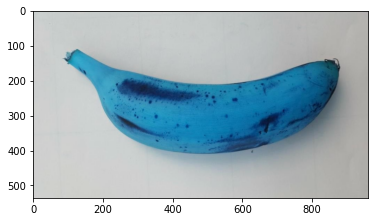

In [ ]:
#try
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))

plt.imshow(bnn_samp)


#4. Extracting Fruit Features

ref: https://github.com/MarshalLeeeeee/Tamura-In-Python
https://stackoverflow.com/questions/28421167/tamuras-coarseness-textural-feature


#5. Data Augmentation

In [ ]:
# https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

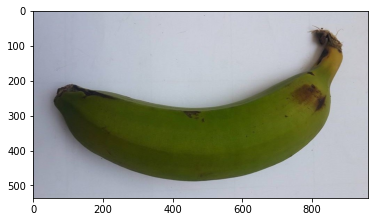

In [ ]:
idx = np.random.randint(0, 273)
image = cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB)
plt.imshow(image)

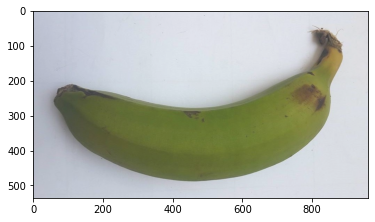

In [ ]:
augmented_image = data_augmentation(image).numpy().astype(int)
plt.imshow(augmented_image)


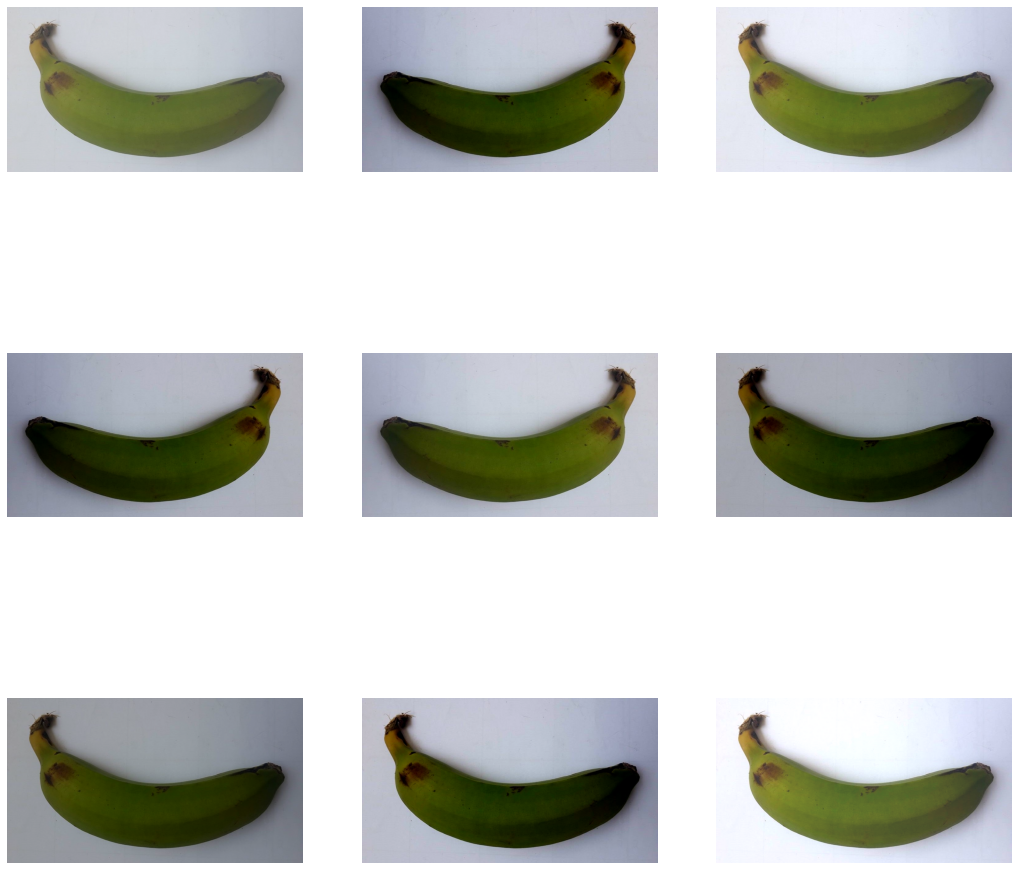

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(9):
    augmented_image = data_augmentation(image).numpy().astype(int)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

#6. Model